# MNIST Handwriting Classification

## Donwload Data

In [1]:
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', as_frame=False) # suboptimal structure for images

C:\Users\srmar\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\datasets\_openml.py:932: FutureWarning: The default value of `parser` will change from `'liac-arff'` to `'auto'` in 1.4. You can set `parser='auto'` to silence this warning. Therefore, an `ImportError` will be raised from 1.4 if the dataset is dense and pandas is not installed. Note that the pandas parser may return different data types. See the Notes Section in fetch_openml's API doc for details.
  warn(


## Examine Data Structure

There are 70,000 handwritten letter in this dataaset, each with 784 features 
- Letters are stored in 28x28 images
- Each feature represents pixel intensity on a scale from 0 to 288 with 0 being white and 288 being black

In [2]:
X, y = mnist.data, mnist.target # separate out pixel data from handwritting labels

In [3]:
X

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [4]:
X.shape

(70000, 784)

In [5]:
y

array(['5', '0', '4', ..., '4', '5', '6'], dtype=object)

In [6]:
y.shape

(70000,)

Write a function to display MNSIT data
- Obtain an images feature vector
- Reshape into 28x28 array
- Display array using `matplotlib.imshow`

In [7]:
import matplotlib.pyplot as plt

def plot_digit(image_data):
    image = image_data.reshape(28, 28)
    plt.imshow(image, cmap='binary')
    plt.axis('off')

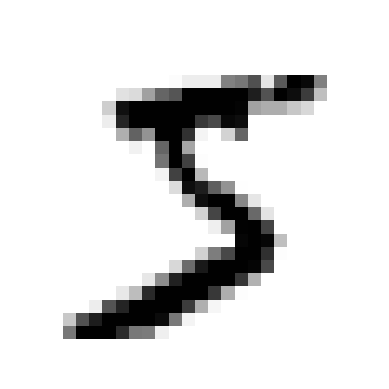

'5'

In [8]:
# plot digit
digit = X[0]
plot_digit(digit)
plt.show()

# check against label
display(y[0])

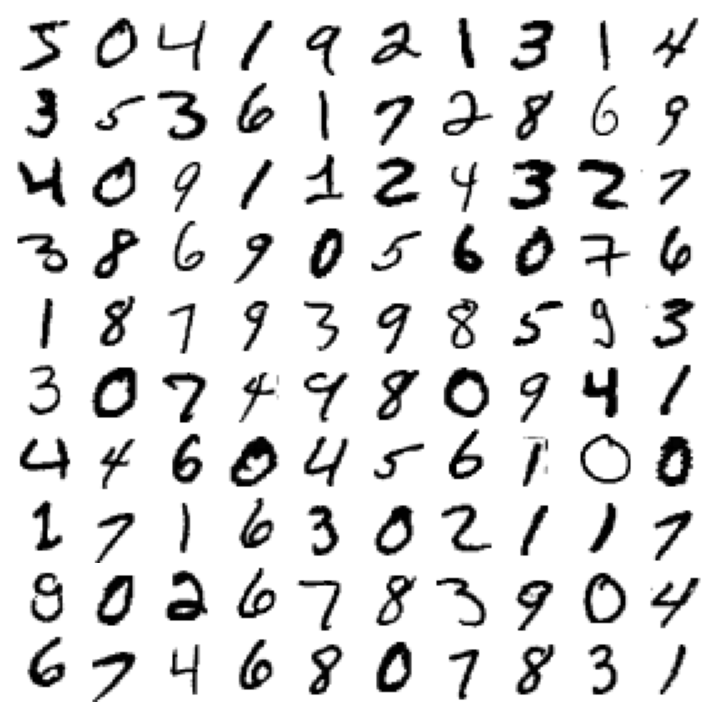

In [9]:
# check out a few more numbers
plt.figure(figsize=(9,9))

for idx, image_data in enumerate(X[:100]):
    plt.subplot(10,10, idx + 1)
    plot_digit(image_data)

plt.subplots_adjust(wspace=0, hspace=0)

plt.show()

## Generate Test and Train Sets

MNIST data returned is already split and shuffled
- Train set = first 60,000 images
- Test set = last 10,000 images

In [10]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

## Train a SGD Classifier

Good for large datasets with high dimensionality 

Pros of SGD
- Tolerant to noise, stochastic process introduces randomness
- Fast convergence, especially at the begining (potential to slow as it approaches optimum)
- Provides good regularization options to prevent overfitting
- Hardware and memory friendly    

In [11]:
# create target vectors -- true for all 5s in the dataset, flase for all other numbers
y_train_5 = (y_train == '5')
y_test_5 = (y_test == '5')

In [12]:
from sklearn.linear_model import SGDClassifier 

sgd_classifier = SGDClassifier(random_state=42) # create classifier
sgd_classifier.fit(X_train, y_train_5) # train on entire training set

SGDClassifier(random_state=42)

In [13]:
sgd_classifier.predict([digit])

array([ True])

## Evaluate Performance

### Cross-Validation 

Use k-fold cross-validation 
- Split the training set into k folds
- Train the model k times, witholding a different fold each time for evaluation

k size dependent on:
- Dataset size, small datasets benefit from larget k but come with increased computational cost
- Variance and bias trade off, smaller k = greater variance
- Larger k may help increase stability of results

In [14]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_classifier, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.95035, 0.96035, 0.9604 ])

Benchmark against DummyClassifier 
- Will classify every image in the most frequent class (non-fives)

In [15]:
from sklearn.dummy import DummyClassifier

dummy_classifier = DummyClassifier()

dummy_classifier.fit(X_train, y_train_5)

print(any(dummy_classifier.predict(X_train)))

False


In [16]:
cross_val_score(dummy_classifier, X_train, y_train_5, cv=3, scoring='accuracy')

array([0.90965, 0.90965, 0.90965])

Dummy has 90% accuracy because only 10% of the data is represented by 5s

Case study in accuracy not always being the best performance measure, particularly for classifiers with skewed datasets

### Confusion Matricies

Determine the number of times the model misclassifies A as B for all A/B pairings 

Split data into folds, but returns predictions made at each test fold

Rows represent actual classes, columns represent predicted classes

In [17]:
from sklearn.model_selection import cross_val_predict

y_train_predict = cross_val_predict(sgd_classifier, X_train, y_train_5, cv=3)

In [18]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_train_5, y_train_predict)

cm

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

### Precision and Recall

Precision measures accuracy of positive predictions
- `precision` = (`true_positives` + `false_positives`)

Recall measures ability to correctly predict positive instances
- `recall` = `true_positives` / (`true_positives` + `false_negatives`)

Binary 5 classifier has high precision but low recall
- 83% accurate when model identifies an image as a 5
- Only able to detect 65% of the 5s in the first place

F-score combines precision and recall score
- `f1_score` = (`precision` * `recall`) / (`precision` + `recall`)

In [19]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_predict)

0.8370879772350012

In [20]:
recall_score(y_train_5, y_train_predict)

0.6511713705958311

In [21]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_predict)

0.7325171197343846

#### Precision / Recall Trade Off

Increasing precision will reduce recall

Select thrshold by leveraging the decision funtions

In [22]:
y_scores = sgd_classifier.decision_function([digit])

y_scores

array([2164.22030239])

In [23]:
threshold = 0

y_digit_prediction = (y_scores > threshold)

y_digit_prediction

array([ True])

In [24]:
# increase threshold and observe change in prediciton 
threshold2 =3000

y_digit_prediction2 = (y_scores > threshold2)

y_digit_prediction2

array([False])

In [25]:
# generate decision function scores for all instances in the training set
y_scores = cross_val_predict(sgd_classifier, X_train, y_train_5, cv=3,
                             method='decision_function')

In [26]:
from sklearn.metrics import precision_recall_curve

# compute precision and recall scores for all thresholds 
precisions, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

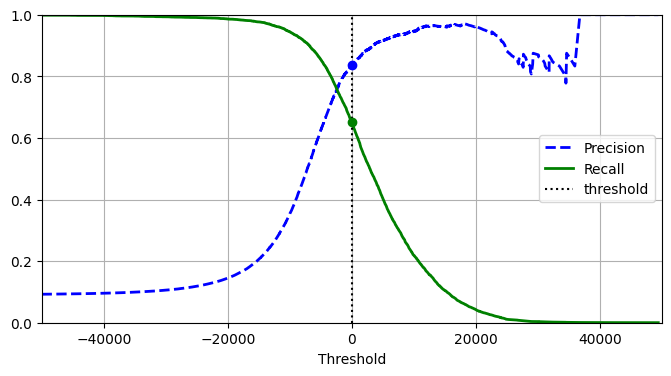

In [39]:
plt.figure(figsize=(8, 4))

plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
plt.vlines(threshold, 0, 1.0, "k", "dotted", label="threshold")

idx = (thresholds >= threshold).argmax()
plt.plot(thresholds[idx], precisions[idx], "bo")
plt.plot(thresholds[idx], recalls[idx], "go")
plt.axis([-50000, 50000, 0, 1])
plt.grid()
plt.xlabel("Threshold")
plt.legend(loc="center right")

plt.show()

#### PR Curve

Opt for the PR curve when:
- Positive class is rare
- You caare more about false positives than false negatives


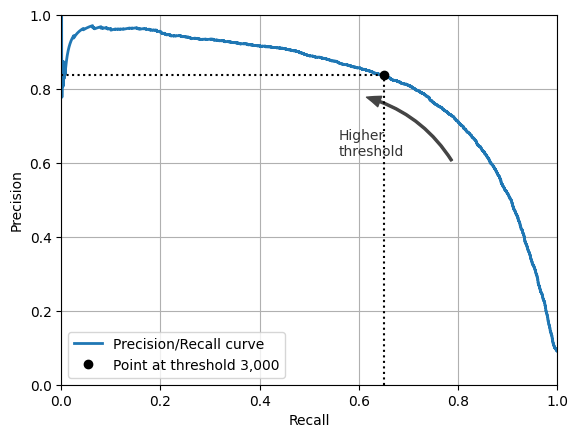

In [41]:
import matplotlib.patches as patches

plt.plot(recalls, precisions, linewidth=2, label="Precision/Recall curve")

plt.plot([recalls[idx], recalls[idx]], [0., precisions[idx]], "k:")
plt.plot([0.0, recalls[idx]], [precisions[idx], precisions[idx]], "k:")
plt.plot([recalls[idx]], [precisions[idx]], "ko",
         label="Point at threshold 3,000")

plt.gca().add_patch(patches.FancyArrowPatch(
    (0.79, 0.60), (0.61, 0.78),
    connectionstyle="arc3,rad=.2",
    arrowstyle="Simple, tail_width=1.5, head_width=8, head_length=10",
    color="#444444"))

plt.text(0.56, 0.62, "Higher\nthreshold", color="#333333")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.grid()
plt.legend(loc="lower left")

plt.show()

Note precision falls steeply after 0.80 recall, select a precision / recall tradeoff before this falloff 

Test 90% precision and find threshold
- Find lowest threshold that gives you 90% precision

In [42]:
idx_for_90_precision = (precisions >= 0.90).argmax() # returns the first index of the maximum value -- in this case where precision is greater than or equal to 0.90

threshold_for_90_precision = thresholds[idx_for_90_precision]

threshold_for_90_precision

3370.0194991439557

In [43]:
y_train_pred_90 = (y_scores >= threshold_for_90_precision)

In [44]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [45]:
recall_at_90_precision = recall_score(y_train_5, y_train_pred_90)

recall_at_90_precision

0.4799852425751706

#### ROC Curve

Plot true positives (recall) against the false postive rate

Can use AUC to evaluate a classifiers performance
- AUC of 1 represents a perfect classifier
- Purely random classifier will have AUC of 0.5

In [47]:
from sklearn.metrics import roc_curve 

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

## Train a Random Forest Classifier

Random Forest Pros:
- Combination of decision trees make Random Forests robust
- Good for handling high-dimensional data and large feature sets 
- Provide mesures of feature importants

In [69]:
from sklearn.ensemble import RandomForestClassifier

forest_classifier = RandomForestClassifier(random_state=42)

In [72]:
y_probas_forest = cross_val_predict(forest_classifier, X_train, y_train_5, cv=3,
                                    method='predict_proba')

In [73]:
y_probas_forest[:2]

array([[0.11, 0.89],
       [0.99, 0.01]])

[negative_prediction, positive_prediction]

In [74]:
y_scores_forest = y_probas_forest[:, 1] # extract estimated probabilites for the positve class
precisions_forest, recalls_forest, thresholds_forest = precision_recall_curve(y_train_5, y_scores_forest)